In [1]:
# limit the thread used by numpy 
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"  
os.environ["MKL_NUM_THREADS"] = "1"

import numpy as np
try:
    import cupy as xp
    # print("has cupy")
except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    # print("no cupy")
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'

from Triangle.Constants import *
from Triangle.Orbit import * 
from Triangle.Noise import *
from Triangle.FFTTools import *
from Triangle.TDI import XYZfromAET, AETfromXYZ

from Triangle_BBH.Waveform import * 
from Triangle_BBH.Response import *
from Triangle_BBH.Utils import *
from Triangle_BBH.Fisher import *

import multiprocessing
# if __name__=='__main__':
#     multiprocessing.set_start_method("fork")
    # multiprocessing.set_start_method("spawn")

has cupy
has GPU waveform


## Prepare models 

### orbit and noise 

In [2]:
# orbit model 
orbit_file = '/home/ubuntu/TDCII/Triangle-Simulator/OrbitData/LISALikeOrbitEclipticTCB/20280322_LISA_3Mkm'
orbit = Orbit(OrbitDir=orbit_file)

# noise PSD model 
PSDfunc = TDIPSDs()

### waveform and response 

In [3]:
# waveform 
mode = "primary"
# mode = "full"
if mode == "primary":
    modes = [(2,2)]
    approx = "IMRPhenomD"
elif mode == "full": 
    modes = [(2,2), (2,1), (3,3), (3,2), (4,4), (4,3)]
    approx = "IMRPhenomHM"
else: 
    raise NotImplementedError("mode not implemented")
use_gpu = True 
WFG = BBHxWaveformGenerator(mode=mode, use_gpu=use_gpu)

# tdi-2.0 response 
FDTDI = BBHxFDTDIResponseGenerator(orbit_class=orbit, waveform_generator=WFG, use_gpu=use_gpu)

## Data simulation (noiseless)

In [4]:
# settings 
t_start = 60. * DAY 
Tobs = 3 * DAY 
t_end = t_start + Tobs 
fsample = 0.0667 
delta_t = 1. / fsample
delta_f = 1. / Tobs
data_frequency = np.arange(int(fsample / 2. / delta_f)) * delta_f + delta_f
print("frequency-domain data length:", len(data_frequency))

frequency-domain data length: 8644


In [5]:
# Correlation spectral densities (CSD) at the median time 
arm_time = (t_end + t_start) / 2. 
arms = dict()
for key in MOSA_labels:
    arms[key] = orbit.LTTfunctions()[key](arm_time)
print("arm lengths:", arms)

tmpxxs = PSDfunc.PSD_X2_unequal(data_frequency, arms)
tmpyys = PSDfunc.PSD_Y2_unequal(data_frequency, arms)
tmpzzs = PSDfunc.PSD_Z2_unequal(data_frequency, arms)
tmpxys = PSDfunc.PSD_X2Y2star_unequal(data_frequency, arms)
tmpyzs = PSDfunc.PSD_Y2Z2star_unequal(data_frequency, arms)
tmpzxs = PSDfunc.PSD_Z2X2star_unequal(data_frequency, arms)
Cov_XYZ = np.conjugate(np.array([
    [tmpxxs, np.conjugate(tmpxys), tmpzxs],
    [tmpxys, tmpyys, np.conjugate(tmpyzs)],
    [np.conjugate(tmpzxs), tmpyzs, tmpzzs]
]) / 4. / delta_f) # covariance matrix of shape (3, 3, Nf), defined as <channel_1 channel_2^*>
InvCov_XYZ = np.linalg.inv(np.transpose(Cov_XYZ, (2, 0, 1))) # inverse covariance matrix of shape (Nf, 3, 3)
print("noise CSD shape:", Cov_XYZ.shape, InvCov_XYZ.shape)

arm lengths: {'12': array(9.97540809), '13': array(10.05615297), '23': array(9.97115167), '21': array(9.97538768), '31': array(10.05816378), '32': array(9.97316576)}
noise CSD shape: (3, 3, 8644) (8644, 3, 3)


In [6]:
# set source parameters 
fiducial_parameters = {
    'chirp_mass': 2e6, # [MSUN]
    'mass_ratio': 0.4719138674211496, 
    'spin_1z': -0.219017,
    'spin_2z': 0.777287,
    'coalescence_time': 62., # [day]
    'coalescence_phase': 3.123620213369193,
    'luminosity_distance': 88470.94592236356, # [MPC]
    'inclination': 0.6928647958196155, # [rad]
    'longitude': 4.484587022801057, # [rad]
    'latitude': 0.9023185939708002, # [rad]
    'psi': 2.050979301490759 # [rad]
    }

# set response keywords 
channel_names = ["X2", "Y2", "Z2"]
response_kwargs = dict(
    modes=modes, 
    tmin=t_start / DAY,
    tmax=t_end / DAY, 
    tc_at_constellation=False, 
    TDIGeneration="2nd", 
    optimal_combination=False, 
    output_by_mode=False, 
)

# calculate tdi response 
data_channels_FD_XYZ = FDTDI.Response(
    parameters=fiducial_parameters, 
    freqs=xp.array(data_frequency),  
    **response_kwargs, 
)

# mask data at the null frequencies (around 0.25n Hz, n=1, 2, ... for Taiji)
mask = np.ones_like(data_frequency, dtype=bool)
for i in range(1, 80):
    mask_idx = np.where(np.abs(data_frequency - 0.025 * i)<i*5e-4)[0] # empirical
    mask[mask_idx] = False  
print("number of dropped data points:", np.where(mask==False)[0].shape)
data_frequency = data_frequency[mask]
data_channels_FD_XYZ = data_channels_FD_XYZ[:, mask]
Cov_XYZ = Cov_XYZ[:, :, mask]
InvCov_XYZ = InvCov_XYZ[mask]
print("shapes of masked data", data_frequency.shape, data_channels_FD_XYZ.shape, Cov_XYZ.shape, InvCov_XYZ.shape)

number of dropped data points: (259,)
shapes of masked data (8385,) (3, 8385) (3, 3, 8385) (8385, 3, 3)


Text(0.5, 1.0, 'TDI responses of IMRPhenomD waveform')

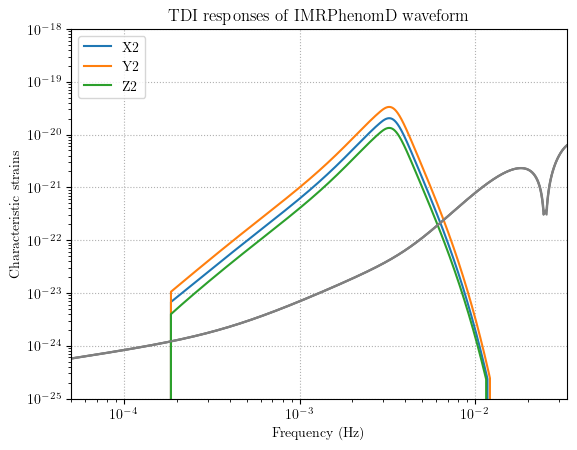

In [7]:
for ich, nch in enumerate(channel_names):
    plt.loglog(data_frequency, (np.abs(data_channels_FD_XYZ[ich].get()) * 2. * data_frequency), label=nch)
    plt.loglog(data_frequency, (np.sqrt(data_frequency * 4. / Tobs * np.abs(Cov_XYZ[ich][ich]))), color="grey")
plt.legend(loc="upper left")
plt.xlim(5e-5, fsample/2)
plt.ylim(1e-25, 1e-18)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic strains")
plt.grid(linestyle=":")
plt.title("TDI responses of "+approx+" waveform")

## Calculate Fisher information matrix

In [8]:
# these are the parameters used in FIM and Likelihood 
parameter_names = [
    'log_chirp_mass',
    'mass_ratio',
    'spin_1z',
    'spin_2z',
    'coalescence_time',
    'coalescence_phase',
    'log_luminosity_distance',
    'cos_inclination',
    'longitude',
    'sin_latitude',
    'psi'
    ]

fiducial_param_arr = ParamDict2ParamArr(fiducial_parameters)
fiducial_param_arr

[6.301029995663981,
 0.4719138674211496,
 -0.219017,
 0.777287,
 62.0,
 3.123620213369193,
 4.946800670728753,
 0.7694193036056729,
 4.484587022801057,
 0.7847660639267573,
 2.050979301490759]

In [9]:
# the waveform wrapper used by FIM 
def waveform_fisher_wrapper(param_dict, freqs):
    param_arr = np.array(list(param_dict.values()))
    p = ParamArr2ParamDict(param_arr)
    test_channels_FD = FDTDI.Response(
        parameters=p,
        freqs=freqs,
        **response_kwargs, 
    )
    if use_gpu:
        test_channels_FD = test_channels_FD.get() 
    return test_channels_FD   

param_steps = dict()
for k in parameter_names:
    # param_steps[k] = -0.01
    param_steps[k] = 1e-6
    
param_dict = dict()
for i in range(len(parameter_names)):
    param_dict[parameter_names[i]] = fiducial_param_arr[i]

FIM = MultiChannelFisher(waveform_generator=waveform_fisher_wrapper, param_dict=param_dict, analyze_param_step_dict=param_steps, frequency=data_frequency, inverse_covariance=InvCov_XYZ, verbose=0)

FIM.auto_test_step()
FIM.calculate_Fisher()
FIM.calculate_errors()
fiducial_param_err = FIM.errors

print("uncertainties of parameters:")
FIM.param_errors

all parameters tested.
uncertainties of parameters:


{'log_chirp_mass': 0.0010129508277945411,
 'mass_ratio': 0.008727523087468337,
 'spin_1z': 0.06379788374527849,
 'spin_2z': 0.13163656369485766,
 'coalescence_time': 0.0012814796051760433,
 'coalescence_phase': 19.997188397821944,
 'log_luminosity_distance': 8.311444983742687,
 'cos_inclination': 19.834826352751367,
 'longitude': 0.24475999427854064,
 'sin_latitude': 0.14949580725793313,
 'psi': 20.393765575110848}

## Likelihood

In [10]:
Like = Likelihood(
    response_generator=FDTDI, 
    frequency=data_frequency, 
    data=data_channels_FD_XYZ, 
    invserse_covariance_matrix=InvCov_XYZ, 
    response_parameters=response_kwargs, 
    use_gpu=use_gpu,
)

number of freuqncies: 8385
min and max frequencies: 3.858024691358025e-06 0.03334876543209876
response kwargs: {'modes': [(2, 2)], 'tmin': 60.0, 'tmax': 63.0, 'tc_at_constellation': False, 'TDIGeneration': '2nd', 'optimal_combination': False, 'output_by_mode': False}


In [11]:
# initialize heterodyned likelihood with base parameters or a base waveform 
# in practice, the base parameters should be obtained via MLE or other methods 
Like.prepare_het_log_like(base_parameters=fiducial_param_arr.copy(), num_het_frequency=128)

### Test likelihood around the truths 

### 1) full likelihood (slow)

100%|██████████| 101/101 [00:01<00:00, 69.51it/s]


Text(0.5, 1.0, 'spin_1z')

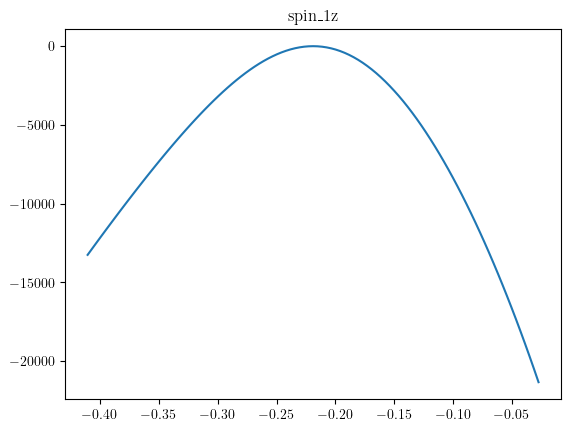

In [12]:
N_test = 101
param_idx = 2 # for example 
test_params = fiducial_param_arr[param_idx] + np.linspace(-1, 1, N_test) * fiducial_param_err[param_idx] * 3

test_lls = np.zeros(N_test)
for i_test in tqdm(range(N_test)):
    tmp_params = fiducial_param_arr.copy()
    tmp_params[param_idx] = test_params[i_test]
    test_lls[i_test] = Like.full_log_like(tmp_params)
plt.plot(test_params, test_lls)
plt.title(parameter_names[param_idx])

### 2) heterodyned likelihood (faster)

100%|██████████| 101/101 [00:01<00:00, 99.23it/s]


Text(0.5, 1.0, 'spin_1z')

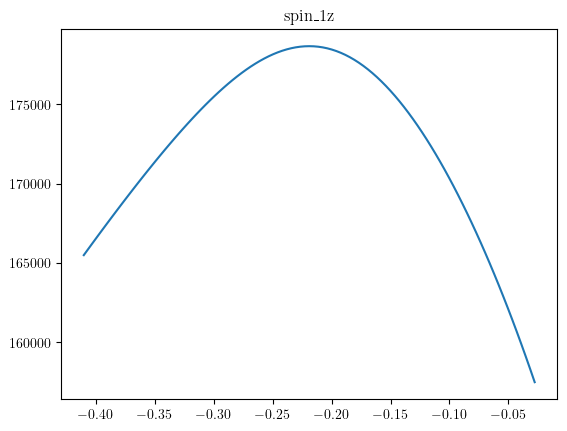

In [13]:
test_hlls = np.zeros(N_test)
for i_test in tqdm(range(N_test)):
    tmp_params = fiducial_param_arr.copy()
    tmp_params[param_idx] = test_params[i_test]
    test_hlls[i_test] = Like.het_log_like(tmp_params)
plt.plot(test_params, test_hlls)
plt.title(parameter_names[param_idx])

### 3) vectorized heterodyned likelihood (fastest)

Text(0.5, 1.0, 'spin_1z')

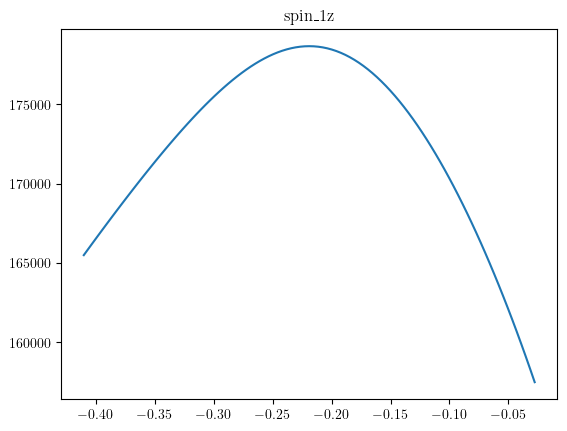

In [14]:
tmp_params = np.zeros((11, N_test))
for i_test in range(N_test):
    tmp_params[:, i_test] = fiducial_param_arr.copy()
    tmp_params[param_idx][i_test] = test_params[i_test]
test_hlls_vec = Like.het_log_like_vectorized(tmp_params)
plt.plot(test_params, test_hlls_vec)
plt.title(parameter_names[param_idx])

### 4) comparison
there could be a little deviation for the intrinsic parameters, maybe because the linear interpolation used in het likelihood is not accurate enough?

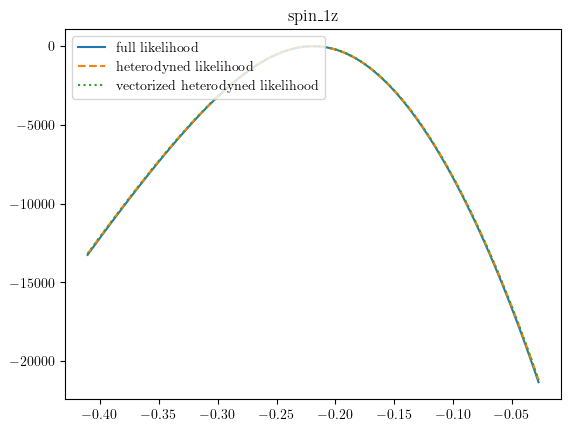

In [15]:
plt.plot(test_params, test_lls - np.max(test_lls), label="full likelihood")
plt.plot(test_params, test_hlls - np.max(test_hlls), linestyle="--", label="heterodyned likelihood")
plt.plot(test_params, test_hlls_vec - np.max(test_hlls_vec), linestyle=":", label="vectorized heterodyned likelihood")
plt.title(parameter_names[param_idx])
plt.legend(loc="upper left")

## Run MCMC Sampling 

In [16]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.utils import TransformContainer
from eryn.moves import GaussianMove, StretchMove, CombineMove
from eryn.utils.utility import groups_from_inds
from eryn.backends import HDFBackend
from eryn.utils import SearchConvergeStopping

import corner

### set hyper parameters and priors 

In [17]:
# set hyper parameters
ndim = 11 # dimension of paramters 
nwalkers = 200 # number of random walkers 
ntemps = 10 # number of temperatures used in parallel tempering 
temps = np.array(list(np.power(2., np.arange(ntemps - 1))) + [np.infty]) 
betas = 1. / temps 
tempering_kwargs=dict(betas=betas)

mcmc_moves = StretchMove(a=2) # mcmc move 
# MHfactor = 2.38 ** 2 / ndim
# MHcov = {'model_0': FIM.CovMatrix * MHfactor}
# mcmc_moves = GaussianMove(MHcov)

stop = None 

# set priors
prior_factor = 5. # 5 sigmas around the truths (only for the parameters without multi-model)
lim_lgMc = [fiducial_param_arr[0] - fiducial_param_err[0]* prior_factor, fiducial_param_arr[0] + fiducial_param_err[0]* prior_factor]
lim_q = [fiducial_param_arr[1] - fiducial_param_err[1]* prior_factor, fiducial_param_arr[1] + fiducial_param_err[1]* prior_factor]
lim_chiz1 = [fiducial_param_arr[2] - fiducial_param_err[2]* prior_factor, fiducial_param_arr[2] + fiducial_param_err[2]* prior_factor]
lim_chiz2 = [fiducial_param_arr[3] - fiducial_param_err[3]* prior_factor, fiducial_param_arr[3] + fiducial_param_err[3]* prior_factor]
lim_tc = [fiducial_param_arr[4] - fiducial_param_err[4] * prior_factor, fiducial_param_arr[4] + fiducial_param_err[4] * prior_factor]
lim_lgD = [fiducial_param_arr[6] - fiducial_param_err[6]* prior_factor, fiducial_param_arr[6] + fiducial_param_err[6]* prior_factor]

lim_phic = [0, TWOPI]
lim_cosinc = [-1, 1]
lim_lam = [0, TWOPI]
lim_sinbeta = [-1, 1]
lim_psi = [0, PI]

# limit priors by the physical bounds 
lim_q = [max(0.1, lim_q[0]), min(1., lim_q[1])]
lim_chiz1 = [max(-0.99, lim_chiz1[0]), min(0.99, lim_chiz1[1])]
lim_chiz2 = [max(-0.99, lim_chiz2[0]), min(0.99, lim_chiz2[1])]
lim_lgD = [max(3, lim_lgD[0]), min(6, lim_lgD[1])]
lim_cosinc = [max(-1, lim_cosinc[0]), min(1, lim_cosinc[1])]
lim_lam = [max(0, lim_lam[0]), min(TWOPI, lim_lam[1])]
lim_sinbeta = [max(-1, lim_sinbeta[0]), min(1, lim_sinbeta[1])]

lims = np.array([lim_lgMc, lim_q, lim_chiz1, lim_chiz2, lim_tc, lim_phic, lim_lgD, lim_cosinc, lim_lam, lim_sinbeta, lim_psi])
lower_lims = lims[:, 0]
upper_lims = lims[:, 1]

priors_in = {i: uniform_dist(lims[i][0], lims[i][1]) for i in range(ndim)}
priors = ProbDistContainer(priors_in)
priors.use_cupy = False

lims 

array([[ 6.29596524,  6.30609475],
       [ 0.42827625,  0.51555148],
       [-0.53800642,  0.09997242],
       [ 0.11910418,  0.99      ],
       [61.9935926 , 62.0064074 ],
       [ 0.        ,  6.28318531],
       [ 3.        ,  6.        ],
       [-1.        ,  1.        ],
       [ 0.        ,  6.28318531],
       [-1.        ,  1.        ],
       [ 0.        ,  3.14159265]])

In [18]:
def eryn_like(params): 
    """params: numpy array of shape (Nevents, Nparams)"""
    return Like.het_log_like_vectorized(np.transpose(params))

In [19]:
# from multiprocessing import Pool
# pool = Pool(processes=multiprocessing.cpu_count())
# pool = Pool(processes=24)
# print(multiprocessing.cpu_count())

init_ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    eryn_like, 
    priors,
    args=[],
    tempering_kwargs=tempering_kwargs,
    stopping_fn=stop,
    stopping_iterations=10,
    moves=mcmc_moves,
    vectorize=True,
    # pool=pool,
)

filename='MCMCResults/HetLogLike.h5'
backend = HDFBackend(filename)
backend.reset(nwalkers=nwalkers, ndims=ndim, ntemps=ntemps, moves=init_ensemble.backend.move_keys)
print('args of the backend =', backend.reset_args)
print('move keys =', backend.move_keys)
print('Initialization flag of backend =', backend.initialized)


ensemble = EnsembleSampler(
    nwalkers,
    ndim,
    eryn_like, 
    priors,
    args=[],
    tempering_kwargs=tempering_kwargs,
    stopping_fn=stop,
    stopping_iterations=10,
    moves=init_ensemble.moves,
    backend=backend,
    vectorize=True,
    # pool=pool,
)

args of the backend = [200, {'model_0': 11}]
move keys = ['StretchMove_0']
Initialization flag of backend = True


In [20]:
# randomize starting positions throughout prior
coords = priors.rvs(size=(ntemps, nwalkers,))
print(coords.shape)
thin_by = 100 
burn = 0
nsteps = int(100000 / thin_by)

ensemble.stopping_fn = None

out = ensemble.run_mcmc(coords, nsteps, burn=burn, progress=True, thin_by=thin_by)

(10, 200, 11)


  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [58:54<00:00, 28.29it/s] 


In [21]:
# resume run after the run is stopped 
thin_by =100
burn = 0
nsteps = int(400000 / thin_by) # this should be far more than enough 

out = ensemble.run_mcmc(ensemble.get_last_sample(), nsteps, burn=burn, progress=True, thin_by=thin_by)

  0%|          | 0/400000 [00:00<?, ?it/s]

100%|██████████| 400000/400000 [3:36:36<00:00, 30.78it/s]  
